In [4]:
import numpy as np
import matplotlib.pyplot as plt
import sparse_stoch_mat_central as sp_stoch_mat
import sys
from scipy.sparse.linalg import spsolve
import timeit
sys.path.append('/home/hcleroy/Extra_Module_py/')
from formated_matplotlib import *
from functions import *

In [31]:
V0a, V0b, V0c = 1.,2.,3.#2.,2.6,4.
kab0,kbc0,kac0 = 1.,1.,1.
Aab,Abc,Aac = 100.,1.,1. # != 1 -> ooe
X0,Xf,n = -5,5,10000 # lower/higher spacial boundary and number of discretizing points
dx = (Xf-X0)/n
print('dx = '+str(dx))
Eab,Ebc,Eac = 0.,0.,0.
steep = 2.
# define all the Vs :
Va = lambda x : 0.5*(1+np.tanh(steep * x)) * V0a
Vb = lambda x : 0.5*(1+np.tanh(steep*x)) * V0b
Vc = lambda x : 0.5*(1+np.tanh(x*steep)) * V0c
""""
# define all the k's
kab = lambda x,*arg : kab0 * np.exp(Va(x)+Eab)*arg[0] # arg is the activity
kba = lambda x,*arg : kab0 * np.exp(Vb(x)+Eab) # no activity but it takes the same argument as kab
kbc = lambda x,*arg : kbc0 * np.exp(Vb(x)+Ebc)*arg[0] # arg is the activity
kcb = lambda x,*arg : kbc0 * np.exp(Vc(x)+Ebc) # no activity but it takes the same argument as kbc
kac = lambda x,*arg : kac0 * np.exp(Va(x)+Eac)*arg[0] # arg is the activity
kca = lambda x,*arg : kac0 * np.exp(Vc(x)+Eac) # no activity but it takes the same argument as kac
"""
# define all the k's
kab = lambda X,*arg : np.array([kab0 * np.exp(max(0,Va(x)-Vb(x))+Eab)*arg[0] for x in X]) if type(X) == np.ndarray else kab0 * np.exp(max(0,Va(X)-Vb(X))+Eab)*arg[0] # arg is the activity
kba = lambda X,*arg : np.array([kab0 * np.exp(max(0,Vb(x)-Va(x))+Eab)for x in X]) if type(X)==np.ndarray else kab0 * np.exp(max(0,Vb(X)-Va(X))+Eab)# no activity but it takes the same argument as kab
kbc = lambda X,*arg : np.array([kbc0 * np.exp(max(0,Vb(x)-Vc(x))+Ebc)*arg[0]for x in X]) if type(X)==np.ndarray else kbc0 * np.exp(max(0,Vb(X)-Vc(X))+Ebc)*arg[0]# arg is the activity
kcb = lambda X,*arg : np.array([kbc0 * np.exp(max(0,Vc(x)-Vb(x))+Ebc)for x in X]) if type(X) == np.ndarray else kbc0 * np.exp(max(0,Vc(X)-Vb(X))+Ebc)# no activity but it takes the same argument as kbc
kac = lambda X,*arg : np.array([kac0 * np.exp(max(0,Va(x)-Vc(x))+Eac)*arg[0]for x in X]) if type(X) ==np.ndarray else kac0 * np.exp(max(0,Va(X)-Vc(X))+Eac)*arg[0]# arg is the activity
kca = lambda X,*arg : np.array([kac0 * np.exp(max(0,Vc(x)-Va(x))+Eac)for x in X]) if type(X) == np.ndarray else kac0 * np.exp(max(0,Vc(X)-Va(X))+Eac)# no activity but it takes the same argument as kac

dx = 0.001


Start by checking the analytical results for the equilibrium case :
The solution for the chemical part does not fix entirely the value of $P_i$, we write is as:
$$
\begin{aligned}
&P_{a,\chi}(x) = 3/S \\
&P_{b,\chi}(x) = 3e^{V_a}/S \\
&P_{c,\chi}(x) = 3e^{V_a}/S
\end{aligned}
$$
$S$ can be defined as : $S = \int \text{d}x P_{a,\chi}(x)+P_{b,\chi}(x)+P_{b,\chi}(x)$

We can also define the diffusion solution as :
$$
\begin{aligned}
&P_{a,diff}(x) = e^{-V_a}/Z \\
&P_{b,diff}(x) = 1/Z\\
&P_{c,diff}(x) = 1/Z
\end{aligned}
$$
With $Z = \int \text{d}x P_{a,diff}(x)+P_{b,diff}(x)+P_{b,diff}(x)$

For these solutions to be consistent together, we write the relation between the normalization constants:
$$
S = 3e^{V_a}Z
$$
Finally considering $\int \text{d}x P_{a,diff}(x)+P_{b,diff}(x)+P_{c,diff}(x)=1$ gives us $Z$

In [32]:
# we first compute the non-normalized diffusion part : 
rho_a_diff,rho_b_diff,rho_c_diff = make_eq_distrib(Va,Vb,Vc,np.linspace(X0,Xf,n,endpoint=False))
# compute the normalization
Z = (sum(rho_a_diff)+sum(rho_b_diff)+sum(rho_c_diff))*dx
# normalize the diffusion part :
rho_a_diff,rho_b_diff,rho_c_diff =rho_a_diff/Z,rho_b_diff/Z,rho_c_diff/Z
# compute the non-normalized chemical part
rho_a_chem,rho_b_chem,rho_c_chem = make_chem_eq(kab,kba,kac,kca,kbc,kcb,Aab,Aac,Abc,np.linspace(X0,Xf,n,endpoint=False))
# compute the normalization for consistency :
S = 3*np.exp(Va(np.linspace(X0,Xf,n,endpoint=False)))*Z
# normalize the chemical part :
rho_a_chem,rho_b_chem,rho_c_chem = rho_a_chem/S,rho_b_chem/S,rho_c_chem/S

In [33]:
Eq_Stoch_Mat = sp_stoch_mat.make_transition_matrix(Va,Vb,Vc,
                                    kab,kba,kbc,kcb,kac,kca,
                                    kab0,kbc0,kac0,
                                    Aab=1.,Abc=1.,Aac=1.,
                                    X0=X0,Xf=Xf,n=n)
rho_a_eq,rho_b_eq,rho_c_eq = get_kernel_stoch_mat(Eq_Stoch_Mat,dx)

In [34]:
Ooe_Stoch_Mat = sp_stoch_mat.make_transition_matrix(Va,Vb,Vc,
                                    kab,kba,kbc,kcb,kac,kca,
                                    kab0,kbc0,kac0,
                                    Aab=Aab,Abc=Abc,Aac=Aac,
                                    X0=X0,Xf=Xf,n=n)
rho_a_ooe,rho_b_ooe,rho_c_ooe = get_kernel_stoch_mat(Ooe_Stoch_Mat,dx)

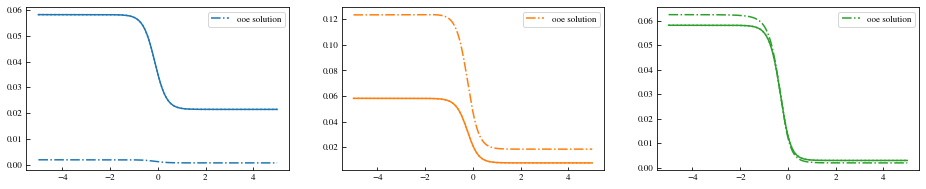

In [35]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

X = np.linspace(X0,Xf,n,endpoint=False)

ax[0].plot(X,rho_a_diff,color=ColorCycle[0])
#ax[0].plot(X,rho_a_chem,color=ColorCycle[0],linestyle='--')
ax[0].plot(X,rho_a_eq,color = ColorCycle[0],linestyle=':')
ax[0].plot(X,rho_a_ooe,color = ColorCycle[0],linestyle='-.',label='ooe solution')

ax[1].plot(X,rho_b_diff,color=ColorCycle[1])
#ax[1].plot(X,rho_b_chem,color=ColorCycle[1],linestyle='--')
ax[1].plot(X,rho_b_eq,color = ColorCycle[1],linestyle=':')
ax[1].plot(X,rho_b_ooe,color = ColorCycle[1],linestyle='-.',label='ooe solution')

ax[2].plot(X,rho_c_diff,color=ColorCycle[2])
#ax[2].plot(X,rho_c_chem,color=ColorCycle[2],linestyle='--')
ax[2].plot(X,rho_c_eq,color = ColorCycle[2],linestyle=':')
ax[2].plot(X,rho_c_ooe,color = ColorCycle[2],linestyle='-.',label='ooe solution')

for i in range(3):
    ax[i].legend()

## All the equilibrium solutions are consistent
#### Check that the fluxes are 0 for the eq solution, and look at the fluxes for the non-eq solution

In [36]:
A_eq_diff__diff_flux = diff_flux(rho_a_diff,Va(X),dx)
A_eq_chem__diff_flux = diff_flux(rho_a_chem,Va(X),dx)
A_eq__diff_flux = diff_flux(rho_a_eq,Va(X),dx)
A_ooe__diff_flux = diff_flux(rho_a_ooe,Va(X),dx)

B_eq_diff__diff_flux = diff_flux(rho_b_diff,Vb(X),dx)
B_eq_chem__diff_flux = diff_flux(rho_b_chem,Vb(X),dx)
B_eq__diff_flux = diff_flux(rho_b_eq,Vb(X),dx)
B_ooe__diff_flux = diff_flux(rho_b_ooe,Vb(X),dx)

C_eq_diff__diff_flux = diff_flux(rho_c_diff,Vc(X),dx)
C_eq_chem__diff_flux = diff_flux(rho_c_chem,Vc(X),dx)
C_eq__diff_flux = diff_flux(rho_c_eq,Vc(X),dx)
C_ooe__diff_flux = diff_flux(rho_c_ooe,Vc(X),dx)

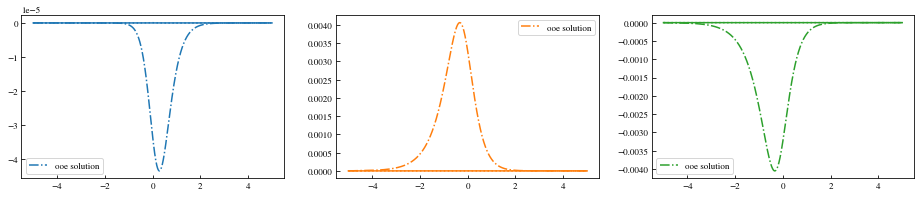

In [37]:
fig,ax = plt.subplots(ncols=3,figsize=(16,3))

X = np.linspace(X0,Xf,n,endpoint=False)

ax[0].plot(X,A_eq_diff__diff_flux,color=ColorCycle[0])
#ax[0].plot(X,A_eq_chem__diff_flux,color=ColorCycle[0],linestyle='--')
ax[0].plot(X,A_eq__diff_flux,color = ColorCycle[0],linestyle=':')
ax[0].plot(X,A_ooe__diff_flux ,color = ColorCycle[0],linestyle='-.',label='ooe solution')

ax[1].plot(X,B_eq_diff__diff_flux,color=ColorCycle[1])
#ax[1].plot(X,B_eq_chem__diff_flux,color=ColorCycle[1],linestyle='--')
ax[1].plot(X,B_eq__diff_flux,color = ColorCycle[1],linestyle=':')
ax[1].plot(X,B_ooe__diff_flux,color = ColorCycle[1],linestyle='-.',label='ooe solution')

ax[2].plot(X,C_eq_diff__diff_flux,color=ColorCycle[2])
#ax[2].plot(X,C_eq_chem__diff_flux,color=ColorCycle[2],linestyle='--')
ax[2].plot(X,C_eq__diff_flux,color = ColorCycle[2],linestyle=':')
ax[2].plot(X,C_ooe__diff_flux,color = ColorCycle[2],linestyle='-.',label='ooe solution')

for i in range(3):
    ax[i].legend()

#### Even the ooe solution has 0 fluxes